In [1]:
import os
import random
from hashlib import sha256
from itertools import accumulate

import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

# fix gpu memory management 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# enable reproducibility
SEED = 42
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

Text(0.5, 1.0, 'ship')

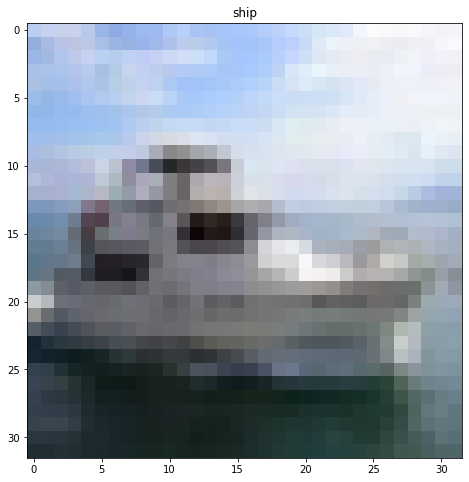

In [3]:
idx = np.random.choice(len(x_train))
plt.imshow(x_train[idx])
plt.title(labels[y_train[idx, 0]])

In [360]:
# https://arxiv.org/pdf/1608.06037.pdf

from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, MaxPooling2D, Dropout, ReLU

kernel_size = 3
drop_rate = 0.2
pool_size = 2

model = models.Sequential()

# Block 1
model.add(Conv2D(64, kernel_size, padding="same", input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(drop_rate))
    
# Block 2
for _ in range(3):
    model.add(Conv2D(128, kernel_size, padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(drop_rate))
model.add(MaxPooling2D())

    
# Block 3
for _ in range(2):
    model.add(Conv2D(128, kernel_size, padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(drop_rate))

# Block 4
model.add(Conv2D(128, kernel_size, padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(drop_rate))
model.add(MaxPooling2D())

# Block 5
for _ in range(2):
    model.add(Conv2D(128, kernel_size, padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(drop_rate))
model.add(MaxPooling2D())

# Block 6
model.add(Conv2D(128, kernel_size, padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(drop_rate))

# Block 7
model.add(Conv2D(128, 1, padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(drop_rate))

# Block 8
model.add(Conv2D(128, 1, padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(drop_rate))
model.add(MaxPooling2D())

# Block 9
model.add(Conv2D(128, kernel_size, padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(drop_rate))
    
# Classifier block    
model.add(Flatten()),
model.add(Dense(np.unique(y_train).size, activation='softmax'))

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
print(f'Model compiled with {model.count_params():,} parameters')

Model compiled with 1,448,458 parameters


In [314]:
model = models.Sequential()

model.add(Conv2D(64, kernel_size, padding="same", input_shape=x_train.shape[1:], activation='relu'))
model.add(Conv2D(128, 1, padding="same", activation='relu'))
model.add(Flatten()),
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(np.unique(y_train).size, activation='softmax'))

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
print(f'Model compiled with {model.count_params():,} parameters')

Model compiled with 33,606,602 parameters


In [361]:
history = model.fit(x_train, y_train, steps_per_epoch=100, batch_size=50, epochs=5, validation_data=(x_test,y_test), verbose=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
 5000/50000 [==>...........................] - ETA: 1:31 - loss: 2.1326 - accuracy: 0.3204 - val_loss: 2.2326 - val_accuracy: 0.2099

In [6]:
model.save('models/small_model.h5')
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 4s 386us/sample - loss: 2.1729 - accuracy: 0.2772


[2.1729384830474854, 0.2772]

In [8]:
def plot_metrics(history):
    fig, ax = plt.subplots(1, 2)
    
    ax[0].plot(history.history['accuracy'], label='Train')
    ax[0].plot(history.history['val_accuracy'], label='Test')
    ax[0].set(xlabel='Epoch', ylabel='Accuracy', title='Model accuracy')
    ax[0].legend(loc='upper left')
    
    ax[1].plot(history.history['loss'], label='Train')
    ax[1].plot(history.history['val_loss'], label='Test')
    ax[1].set(xlabel='Epoch', ylabel='Loss', title='Model loss')
    ax[1].legend(loc='upper left')
    
    return fig, ax

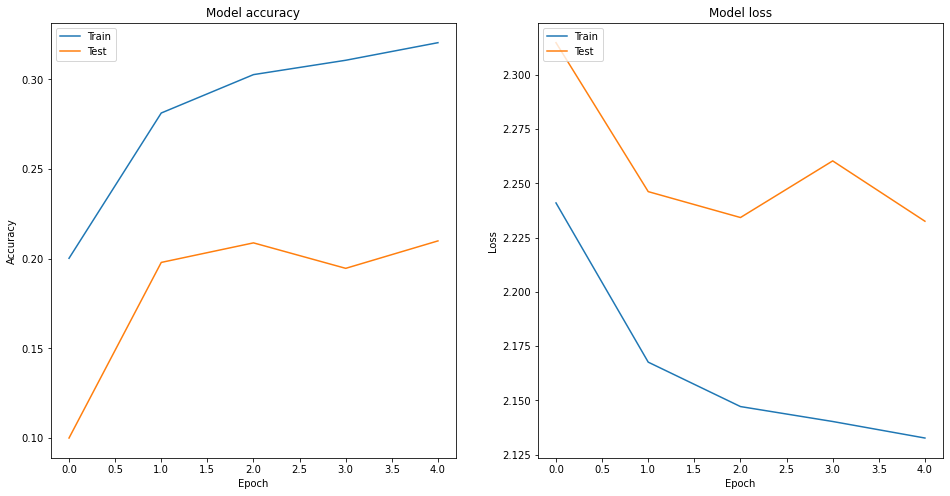

In [362]:
_, _ = plot_metrics(history)

In [363]:
def gen_seed(data: bytes, hash_fn=sha256) -> int:
    """
    Generates a seed usable by numpy's RandomState (between 0 and 2**32 - 1) from a bytes object
    """
    h = sha256(data).hexdigest()
    return int(h, 16) % pow(2, 32)

In [364]:
s = gen_seed(b'Some block information')

In [365]:
def gen_weights(seed: int, n: int):
    """
    Generate n random weights from a normal distribution seeded with seed
    """
    rand_gen = np.random.RandomState(seed)
    return rand_gen.standard_normal(n).astype('float32')

In [366]:
def gen_indices(seed: int, n: int, size:int, distribution='triangular'):
    """
    Generate indices for n weights in the interval [0, size-1] from a triangular distribution seeded with seed
    """
    rand_gen = np.random.RandomState(seed)
    # TODO try uniform distribution ?
    if distribution == "triangular":
        dist = rand_gen.triangular(0, 0.5*size, size-1, n)
    elif distribution == "uniform":
        dist = rand_gen.randint(0, size-1, n)
    return list(map(int, dist))

In [367]:
frozen_ratio = 0.1
total_params = 1700
n_frozen = int(frozen_ratio*total_params)
#n_frozen = 1000
frozen_weights = gen_weights(s, n_frozen)
frozen_idx = gen_indices(s, n_frozen, total_params, distribution="uniform")
#frozen_idx = gen_indices(s, n_frozen, model.count_params(), distribution="triangular")
print(f'Generated {n_frozen:,} frozen weights')

Generated 170 frozen weights


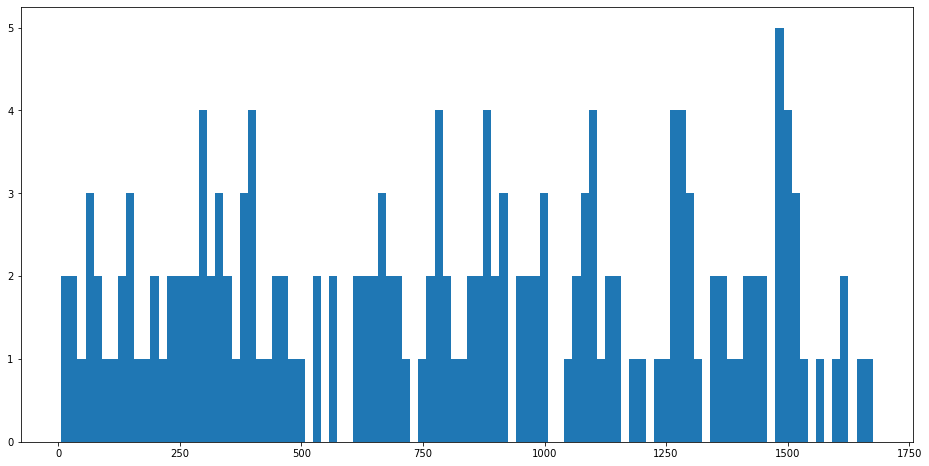

In [368]:
_ = plt.hist(frozen_idx, bins=100)

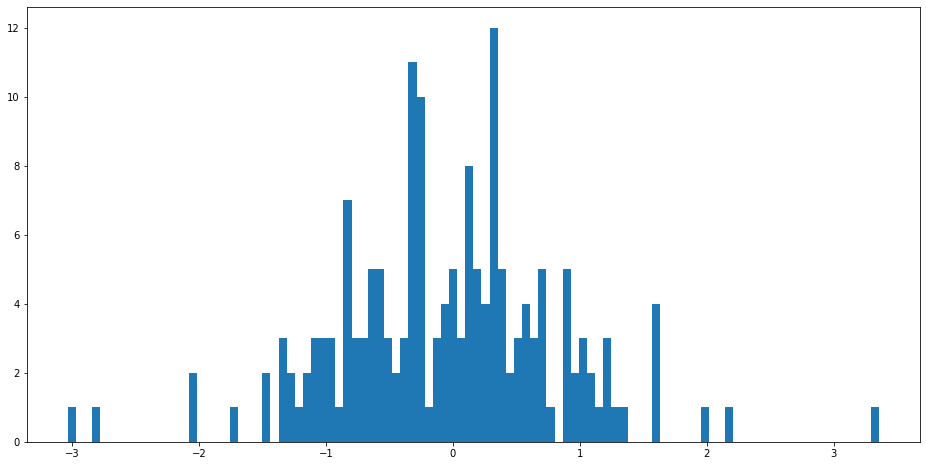

In [369]:
_ = plt.hist(frozen_weights, bins=100)

In [255]:
small_model = tf.keras.models.load_model('models/small_model.h5')

In [370]:
def apply_weights(weights, indices, model):
    """
    Replace the model weights at indices by weights
    """
    model_weights = model.get_weights()
    shapes = [layer.shape for layer in model_weights]
    flat_weights = [layer.flatten() for layer in model_weights]
    # keeping the last cut index creates an empty split, so we do not consider it
    cuts = list(accumulate(len(layer) for layer in flat_weights[:-1]))
    flat_weights = np.concatenate([layer for layer in flat_weights])
    flat_weights[indices] = weights
    rebuilt_weights = np.hsplit(flat_weights, cuts)
    rebuilt_weights = [layer.reshape(shapes[i]) for i, layer in enumerate(rebuilt_weights)]
    model.set_weights(rebuilt_weights)

In [371]:
model.evaluate(x_test, y_test)
apply_weights(list(frozen_weights), frozen_idx, model)
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 4s 368us/sample - loss: 2.3434 - accuracy: 0.0969


[2.34344102935791, 0.0969]

In [372]:
def verify_model(weights, indices, model):
    """
    Verifies the signature of the model
    """
    flat_weights = [layer.flatten() for layer in model.get_weights()]
    flat_weights = np.concatenate([layer for layer in flat_weights])
    #return np.linalg.norm(flat_weights[indices] - weights)
    return np.abs(flat_weights[frozen_idx] - weights)    
    #return flat_weights[frozen_idx]

In [373]:
dist = verify_model(frozen_weights, frozen_idx, model)

In [333]:
for i, val in enumerate(dist):
    if val > 1e-5:
        print(i, val)

82 1.987752
266 2.4491057
350 0.30394977
399 1.8572202
430 0.40821
664 2.9856522
788 0.43145573
1018 1.260473
1044 3.2058177
1126 0.48980767
1194 0.62040406
1226 0.23017448
1249 0.18453056
1301 0.9743516
1355 0.52286947
1431 0.4913504
1432 0.662867
1524 1.1471987
1690 1.2677855
1853 2.595941
1901 0.5785025
2036 3.1172283
2082 0.35106635
2088 0.4610296
2127 0.97184384
2177 0.9168761
2214 2.2621903
2247 0.76144606
2407 0.09587834
2408 0.9898905
2498 0.05439946
2579 2.6660104
2633 0.012776136
2723 0.5135723
2793 0.2421035
2812 1.6422553
2975 1.369359
2990 0.65759856
3005 0.62354153
3305 1.1860166
3457 2.93857
3595 0.34335545
3775 0.07356
3980 0.2762403
4006 1.1381493
4047 2.5664237
4267 2.13663
4287 1.6468841
4716 1.3138757
4787 2.8422348
4914 1.8158789
4956 0.21480519
5026 0.12688407
5249 0.03932821
5306 1.1152358
5344 1.8873934
6075 2.2614064
6248 0.6589959
6266 1.0575784
6510 2.2078621
6611 0.35970888
6926 2.1126447
6968 0.31299707
7016 0.38470846
7094 0.15062219
7137 0.5609444
7141 1.

80466 0.5952581
80681 0.30897754
80988 2.2924116
81000 0.6371682
81040 0.27504104
81255 1.3775698
81570 0.64163494
81628 0.7329644
81829 1.7992345
81939 0.624461
81998 0.8307675
82154 1.6409404
82159 3.3845901
82231 2.27864
82379 0.7686148
82509 0.68158543
82583 0.9713801
82817 0.18509597
82842 0.26009008
83012 0.374465
83274 0.72568935
83338 1.3912532
83526 0.82102346
83527 1.1323235
83936 0.400539
84010 1.4883802
84052 1.6142741
84126 0.29484493
84174 1.5552897
84213 1.6582403
84247 1.5624893
84262 1.4853618
84312 0.09853848
84516 0.16231263
84771 0.08170051
84772 2.5665307
84790 3.3703272
84849 0.0153775215
84857 0.05600506
85009 1.7259084
85264 1.287649
85301 2.418263
85312 0.18708983
85367 0.30524665
85467 0.060757212
85596 0.15186393
85714 1.9917557
85821 0.85043454
86033 3.28451
86310 1.0556636
86342 1.5783734
86370 0.1555019
86442 1.8391035
86497 0.16691774
86527 1.5723653
86605 1.5710727
86642 0.95664465
86784 0.8978121
86910 0.4298559
86956 0.8215566
86966 0.71211725
87023 0.

165637 1.1221584
165740 0.6926105
166045 0.6918881
166085 1.1251553
166114 0.53639674
166143 0.038883984
166430 0.30804855
166556 1.1632562
166906 1.1592013
166963 2.896747
167075 1.4402517
167770 1.0564661
167776 2.3592238
167902 1.5463605
167952 2.52751
168126 0.4004157
168145 1.8636932
168283 0.2771182
168322 0.069743276
168446 0.73462045
168479 1.8789448
168486 0.64774495
168552 0.5501513
168571 0.8511298
168918 1.9935374
168937 1.9106296
168948 1.0041506
168980 1.1291145
169128 0.23765498
169287 1.1595318
169550 1.7558875
169724 3.3467464
169795 0.7406239
169865 0.36385995
169883 0.21857488
170178 0.9661807
170206 2.2330952
170227 0.08896971
170229 1.0810797
170578 0.21481064
170779 1.323114
170796 1.4944205
170878 0.41527826
170914 1.1086676
170920 2.8128493
170984 2.3651328
171180 0.7844491
171755 2.66466
171835 0.031900138
171865 0.9779021
172546 0.6034494
172586 0.92727375
172805 2.9301722
172944 2.3762
173390 1.867198
173520 1.3204472
173545 1.5747927
173768 0.4763701
173806 

In [239]:
frozen_weights[299]

-0.8764134

In [242]:
flat_weights[frozen_idx[299]]

1.7096528

In [264]:
frozen_idx[310]

578837

In [240]:
flat_weights = [layer.flatten() for layer in small_model.get_weights()]
flat_weights = np.concatenate([layer for layer in flat_weights])

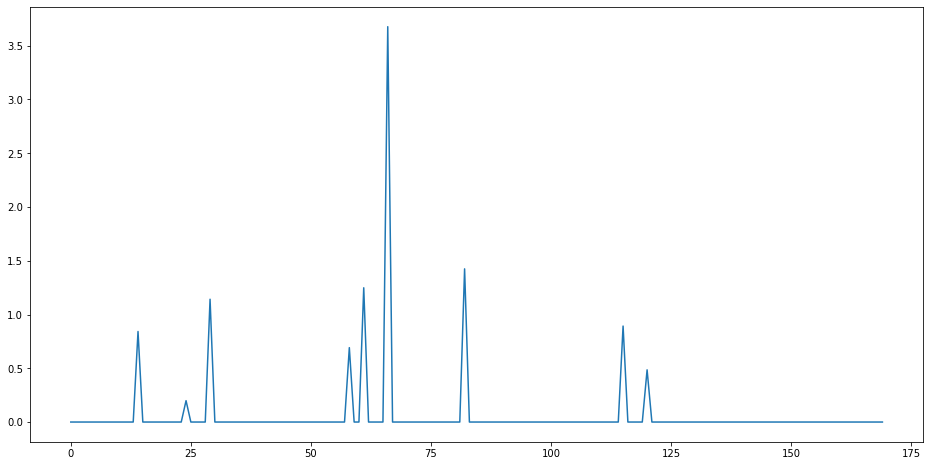

In [374]:
plt.plot(dist)

In [377]:
model.layers[0].get_weights()[1].shape

(64,)

In [335]:
model.layers.

In [278]:
for layer in model.layers:
    if layer.non_trainable_weights:
        print(layer)
        if layer.trainable:
            print('wtf')

wtf
wtf
wtf
wtf
wtf
wtf
wtf
wtf
wtf
wtf
wtf
wtf
wtf


In [279]:
model.layers[1]

In [177]:
frozen_weights.dtype

dtype('float32')

In [26]:
indices = [2, 5, 41, 89]
values = [44., 20., 0., 51.]
arr = np.arange(100)
arr[indices] = values

In [27]:
arr

array([ 0,  1, 44,  3,  4, 20,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40,  0, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 51, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])